# Learning without Forgetting - LwF
Paper: [Learning without Forgetting](https://arxiv.org/abs/1606.09282)

Learning without Forgetting (LwF) is an architectural method for continual learning that allows a model to learn new tasks while retaining knowledge of previously learned tasks. The key idea is to use Knowledge Distillation (KD) on the outputs reletated to the old tasks, with the input being the new task data. This way, the model can learn new tasks without forgetting the old ones and also improve its performance with backward knowledge transfer.

In [1]:
import copy
from typing import Optional
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(48)
import torch
torch.manual_seed(48)
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import IterableDataset, DataLoader
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Dataset
The dataset used is SplitCIFAR-10 which is a modified version of CIFAR-10. The dataset is split into 5 tasks, each containing 2 classes. The model is trained on one task at a time, and the performance is evaluated on all tasks.

In [2]:
class SplitCIFAR10(IterableDataset):
    def __init__(self, classes_per_split=2, task_duration=1000, root="./data", download=True, transform=None, train=True):
        self.root = root
        self.transform = transforms.ToTensor() if transform is None else transform
        self.download = download
        self.train = train
        self.dataset = datasets.CIFAR10(root=self.root, train=train, download=self.download)
        self.classes_per_split = classes_per_split
        self.buckets = self.create_buckets()
        self.task_duration = task_duration

    def create_buckets(self):
        # Create buckets of samples with classes_per_split classes in each bucket
        targets = np.array(self.dataset.targets)
        classes = np.unique(targets)
        # check if classes_per_split is a divisor of the number of classes
        if len(classes) % self.classes_per_split != 0:
            raise ValueError(f"Number of classes {len(classes)} is not divisible by classes_per_split {self.classes_per_split}")
        num_buckets = len(classes) // self.classes_per_split
        buckets = []
        for i in range(num_buckets):
            start = i * self.classes_per_split
            end = start + self.classes_per_split
            bucket_classes = classes[start:end]
            bucket_indices = np.isin(targets, bucket_classes)
            buckets.append(np.where(bucket_indices)[0])
        return buckets
    
    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.buckets) * self.task_duration

    def __iter__(self):
        for current_bucket in range(len(self.buckets)):
            for _ in range(self.task_duration):
                bucket = self.buckets[current_bucket]
                idx = np.random.choice(bucket)
                img, target = self.dataset[idx]
                img = self.transform(img)
                target = torch.tensor(target, dtype=torch.long)
                task_id = torch.tensor(current_bucket, dtype=torch.long)
                yield img, target, task_id

In [3]:
train_dataset = SplitCIFAR10(task_duration=10000)
test_dataset = SplitCIFAR10(task_duration=1000, train=False)

## Model
The model used is a CNN with a multi-head classification output. One head is used for each task. A head can be added or removed dynamically, allowing the model to adapt to new tasks without retraining the entire model.

In [4]:
class FullClassifier(nn.Module):
    def __init__(self, in_out_shape=(3, 32, 32), classes=10, tasks=1):
        super(FullClassifier, self).__init__()
        self.conv_depth = 3
        self.ff_depth = 3
        self.conv_width = 32
        self.conv = nn.Sequential()
        self.conv.append(nn.BatchNorm2d(in_out_shape[0]))
        self.conv.append(nn.Conv2d(in_out_shape[0], self.conv_width, kernel_size=3, stride=1, padding=1, padding_mode="reflect"))
        width = self.conv_width
        for i in range(self.conv_depth):
            self.conv.append(nn.Conv2d(width, 2*width, kernel_size=3, stride=1, padding=1, padding_mode="reflect"))
            self.conv.append(nn.BatchNorm2d(2*width))
            self.conv.append(nn.ReLU())
            self.conv.append(nn.MaxPool2d(kernel_size=2, stride=2))
            width *= 2
        
        self.conv.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.conv.append(nn.Flatten())
        
        self.ff = nn.Sequential()
        for i in range(self.ff_depth):
            self.ff.append(nn.Linear(width, width))
            self.ff.append(nn.BatchNorm1d(width))
            self.ff.append(nn.ReLU())
        
        self.heads_in = width
        self.heads = nn.ModuleList()
        for i in range(tasks):
            self.heads.append(nn.Linear(width, classes))

    def add_head(self, classes: int):
        self.heads.append(nn.Linear(self.heads_in, classes))

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.ff(x)
        out = []
        for i in range(len(self.heads)):
            out.append(self.heads[i](x))
        return out     

## Training
To train the model, we need a teacher for the KD loss. The teacher is a frozen copy of the model trained on the previous tasks. The model is trained on the new task data to minimize the cross-entropy, while also minimizing the KD loss with respect to the teacher's outputs for the old tasks.

In [5]:
class LWFClassifier(nn.Module):
    def __init__(self, in_out_shape=(3, 32, 32), classes=10):
        super(LWFClassifier, self).__init__()

        self.old_model: Optional[FullClassifier] = None
        self.classes = classes
        self.model = FullClassifier(in_out_shape, classes)
        self.optimizer_params = {
            "lr": 1e-3,
            "momentum": 0.9,
            "weight_decay": 0.0005
        }
        self.optimizer = torch.optim.SGD(self.model.parameters(), **self.optimizer_params)
        self.loss = nn.CrossEntropyLoss()
        self.loss_old = lambda logx, logy: -torch.sum(torch.softmax(logy, dim=1) * torch.log_softmax(logx, dim=1), dim=1).mean()

        self.error_window_max_len = 32
        self.error_threshold = 10
        self.error_window = []
        self.accuracy_window = []
        self.error_window_sum = 0
        self.accuracy_window_sum = 0

        self.temperature = 2
        self.old_loss_weight = 1

    def new_error(self, error: float, accuracy: float) -> tuple[float, float]:
        if len(self.error_window) >= self.error_window_max_len:
            self.error_window_sum -= self.error_window.pop(0)
            self.accuracy_window_sum -= self.accuracy_window.pop(0)
        self.error_window.append(error)
        self.accuracy_window.append(accuracy)
        self.error_window_sum += error
        self.accuracy_window_sum += accuracy

        mean = self.error_window_sum / len(self.error_window)
        accuracy_mean = self.accuracy_window_sum / len(self.accuracy_window)
        std = (sum((x - mean) ** 2 for x in self.error_window) / len(self.error_window)) ** 0.5
        return mean, std, accuracy_mean
    
    def new_task(self, classes: int):
        """Adds a new task to the model and freezes the old model.
        The number of classes can differ between tasks.
        """

        self.old_model = copy.deepcopy(self.model)
        self.model.add_head(classes)
        for param in self.old_model.parameters():
            param.requires_grad = False
        self.old_model.eval()
        self.model.train()
        self.classes = classes
        self.optimizer = torch.optim.SGD(self.model.parameters(), **self.optimizer_params)
        self.error_window = []
        self.accuracy_window = []
        self.error_window_sum = 0
        self.accuracy_window_sum = 0
        self.batches_with_high_loss = 0

    def forward(self, x: torch.Tensor):
        x_new = self.model(x)
        x_old = self.old_model(x) if self.old_model is not None else []
        return x_new, x_old

    def predict(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """Returns the indices of the predicted classes for each task in the batch."""

        x = self.model(x)
        
        output = torch.zeros_like(t, dtype=torch.long)
        for batch_index in range(t.shape[0]):
            task_id = t[batch_index]
            if task_id >= len(x):
                raise ValueError(f"Task id {task_id} out of range")
            output[batch_index] = x[task_id][batch_index].argmax(dim=0)
        
        return output

    def test(self, test_loader: DataLoader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            loading_bar = tqdm(test_loader, desc="Testing", total=len(test_loader))
            confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
            for x, y, t in loading_bar:
                x = x.to(device)
                y = y.to(device)
                t = t.to(device)
                known_tasks_mask = t < len(self.model.heads)
                if not known_tasks_mask.any():
                    continue
                x = x[known_tasks_mask]
                y = y[known_tasks_mask]
                t = t[known_tasks_mask]
                outputs = self.predict(x, t)
                total += y.shape[0]
                correct += (outputs == y).sum().item()
                accuracy = correct / total
                confusion_matrix += torch.bincount(y * 10 + outputs, minlength=100).reshape(10, 10)
                loading_bar.set_postfix(accuracy=f"{accuracy:.2%}")
        return confusion_matrix

    def fit(self, train_dataset: IterableDataset, test_dataset: IterableDataset):
        train_loader = DataLoader(train_dataset, batch_size=32)
        test_loader = DataLoader(test_dataset, batch_size=32)
        
        loading_bar = tqdm(train_loader, desc="Training", unit="batch")
        mean, std = 0, 0
        confusion_matrices = []
        for batch in loading_bar:
            self.model.train()
            img, label, task = batch
            img = img.to(device)
            label = label.to(device)
            task = task.to(device)

            max_task_id = task.max().item()
            if max_task_id > len(self.model.heads) - 1:
                confusion_matrices.append(self.test(test_loader))
                self.new_task(self.classes)
                continue # skip this batch for simplicity, this batch might contain mixed tasks

            self.optimizer.zero_grad()
            output, old_output = self(img)
            loss, loss_new, loss_old = self.criterion(output, old_output, label)
            accuracy = (output[-1].argmax(dim=1) == label).sum().item() / label.shape[0]
            mean, std, accuracy_mean = self.new_error(loss_new.item(), accuracy)

            loss.backward()
            self.optimizer.step()
            loading_bar.set_postfix({
                "acc_mean": f"{accuracy_mean:.2%}",
                "l_new": f"{loss_new.item():.3f}", 
                "l_old": f"{loss_old.item():.3f}", 
                "mean": f"{mean:.3f}", 
                "std": f"{std:.3f}",
                "n": len(self.model.heads)})
        confusion_matrices.append(self.test(test_loader))
        return confusion_matrices
    
    def criterion(self, output: list[torch.Tensor], old_output: list[torch.Tensor], target: torch.Tensor):
        loss_new = self.loss(output[-1], target)
        loss_old = torch.zeros_like(loss_new)
        for i in range(len(old_output)):
            loss_old += self.old_loss_weight * self.loss_old(output[i], old_output[i])
        return loss_new + loss_old, loss_new, loss_old

In [6]:
model = LWFClassifier()

In [7]:
confusion_matrices = model.fit(train_dataset, test_dataset)

Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

### Confusion Matrix
A confusion matrix is calculated at the end of each task. We can see that the performance on the old tasks is maintained while the model learns new tasks.

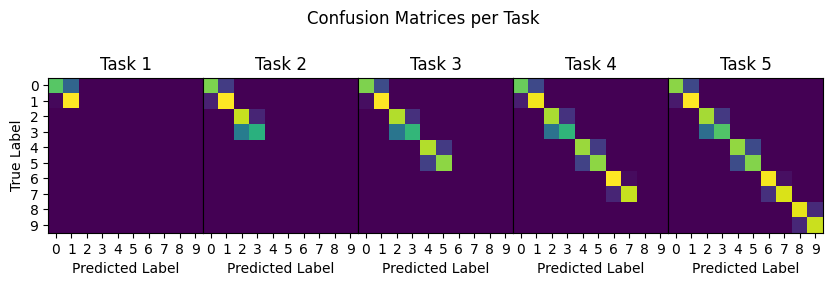

In [8]:
plt.figure(figsize=(10, 3))
plt.suptitle("Confusion Matrices per Task")
plt.subplots_adjust(wspace=0, hspace=0)
for i, confusion_matrix in enumerate(confusion_matrices):
    plt.subplot(1, len(confusion_matrices), i + 1)
    plt.imshow(confusion_matrix.cpu(), interpolation='nearest')
    plt.title(f"Task {i+1}")
    plt.xlabel("Predicted Label")
    if i == 0:
        plt.ylabel("True Label")
    plt.xticks(np.arange(10))
    if i == 0:
        plt.yticks(np.arange(10))
    else:
        plt.yticks([])
plt.show()